In [2]:
#### Dependencies

from PIL import Image
from PIL import ImageDraw

import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sys
import timeit


In [3]:
#### Global variables

model = {}
simplified_model = {}
map_8bit_to_3bit = [i // 32 for i in range(256)]


In [9]:
#### Functions

def load_img(img_path):
    return Image.open(img_path).convert('L')

def get_img_size(img):
    return img.size

def print_img(img):
    plt.imshow(img, cmap='gray')
    
def get_img_colors(img, sampling_count):
    img_width, img_height = get_img_size(img)
    
    sample_width = int(img_width / sampling_count)
    sample_height = int(img_height / sampling_count)
    
    half_sample_width = int(sample_width/2)
    half_sample_height = int(sample_height/2)

    img_colors = []

    width_constraint = img_width - (2 * sample_width)
    height_constraint = img_height - (2 * sample_height)
   
    row = 0
    for point_x in range(half_sample_width, img_width, sample_width):
        if(row == sampling_count):
            break
        column = 0
        for point_y in range(half_sample_height, img_height, sample_height):
            if(column == sampling_count):
                break
            img_colors.append(img.getpixel((point_x, point_y)))
                
            column += 1
                
        row += 1
            
    return img_colors

def construct_img(img_colors, img_dimension, sampling_count):
    img_new = Image.new('RGB', (img_dimension), (255, 255, 255))
    draw = ImageDraw.Draw(img_new)
    
    img_new_width = img_dimension[0]
    img_new_height = img_dimension[1]

    sample_width = int(img_new_width/sampling_count)
    sample_height = int(img_new_height/sampling_count)
    loop_count = 0

    img_colors_len = len(img_colors)

    for w in range(0, img_new_width, sample_width):
        for h in range(0, img_new_height, sample_height):
            if(loop_count == img_colors_len):
                break
            
            current_color = (img_colors[loop_count], img_colors[loop_count], img_colors[loop_count])
            draw.rectangle((w, h, w+sample_width, h+sample_height), fill=current_color)
            loop_count += 1
    
    return img_new

def get_3bit_colors(img_colors):
    loop_count = 0
    
    for img_color in img_colors:
        img_colors[loop_count] = map_8bit_to_3bit[img_color]
        
        loop_count += 1
        
    return img_colors

def get_img_matrix(img_colors):
    img_matrix = [] 
    loop_count = 0
    
    for row in range(8):
        new_img_matrix_row = []
        for col in range(8):
            new_img_matrix_row.append(img_colors[loop_count])
            
            loop_count += 1
        img_matrix.append(new_img_matrix_row)
        
    return img_matrix

def get_img_features(img, sampling_count, angle, distance):
    img_colors = get_img_colors(img, sampling_count)
    img_3bit_colors = get_3bit_colors(img_colors)
    img_matrix = get_img_matrix(img_3bit_colors)
    
    glcm_matrix = [[0 for j in range(8)] for i in range(8)] 
    non_zero_glcm_indexes = []
    
    total_pair = 0
    loop_count = 0
    row_id = 0
    for row in img_matrix:
        col_id = 0
        for col in row:
            current_color = col
            neighbor_color = 999
            
            try:
                if(angle == 0):
                    neighbor_color = img_matrix[row_id][col_id + distance]
                elif(angle == 45):
                    neighbor_color = img_matrix[row_id - distance][col_id + distance]
                elif(angle == 90):
                    neighbor_color = img_matrix[row_id - distance][col_id]
                elif(angle == 135):
                    neighbor_color = img_matrix[row_id - distance][col_id - distance]
                    
                glcm_matrix[current_color][neighbor_color] += 1
                total_pair += 1
                
                current_index = (row_id, col_id)
                if(not current_index in non_zero_glcm_indexes):
                    non_zero_glcm_indexes.append(current_index)
            except Exception:
                pass            
            
            col_id += 1
            
        row_id += 1
        
    # Contrast
    img_contrast = 0
    
    # Correlation
    avg_row_glcm = 0
    avg_col_glcm = 0
    
    # Energy
    img_energy = 0
    
    # Homogenity
    img_homogenity = 0
    
    for non_zero_glcm_index in non_zero_glcm_indexes:
        non_zero_glcm_row_id = non_zero_glcm_index[0]
        non_zero_glcm_col_id = non_zero_glcm_index[1]
        
        glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id] /= total_pair
        
        # calculate image's contrast
        img_contrast += ((non_zero_glcm_row_id - non_zero_glcm_col_id) ** 2) * glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id]
        
        # calculate image's correlation
        avg_row_glcm += non_zero_glcm_row_id * glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id]
        avg_col_glcm += non_zero_glcm_col_id * glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id]
        
        # calculate image's energy
        img_energy += glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id] ** 2
        
        # calculate image's homogenity
        img_homogenity += glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id] / (1 + abs(non_zero_glcm_row_id - non_zero_glcm_col_id))
        
    # Correlation
    sigma_row_glcm = 0
    sigma_col_glcm = 0
        
    for non_zero_glcm_index in non_zero_glcm_indexes:
        non_zero_glcm_row_id = non_zero_glcm_index[0]
        non_zero_glcm_col_id = non_zero_glcm_index[1]
        
        # calculate image's correlation
        sigma_row_glcm += ((non_zero_glcm_row_id - avg_row_glcm) ** 2) * glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id]
        sigma_col_glcm += ((non_zero_glcm_col_id - avg_col_glcm) ** 2) * glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id]
        
    # Correlation
    sigma_row_glcm = math.sqrt(sigma_row_glcm)
    sigma_col_glcm = math.sqrt(sigma_col_glcm)
    img_correlation = 0
    
    if(sigma_row_glcm == 0 or sigma_col_glcm == 0):
        sigma_row_glcm = 1
        sigma_col_glcm = 1
    
    for non_zero_glcm_index in non_zero_glcm_indexes:
        non_zero_glcm_row_id = non_zero_glcm_index[0]
        non_zero_glcm_col_id = non_zero_glcm_index[1]
        
        # calculate image's correlation
        img_correlation += ((non_zero_glcm_row_id - avg_row_glcm) * (non_zero_glcm_col_id - avg_col_glcm) * glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id]) / (sigma_row_glcm * sigma_col_glcm)
    
    glcm_values = (img_contrast, img_correlation, img_energy, img_homogenity)
    
    return glcm_values

# Modelling

def initialize_model():
    global model
    global simplified_model
    
    model = {}
    simplified_model = {}
    
def get_class_names(training_folder_path):
    return os.listdir(training_folder_path)

def add_classes_to_model(class_names):
    for class_name in class_names:
        if not class_name in model:
            model[class_name] = []
        if not class_name in simplified_model:
            simplified_model[class_name] = (0, 0, 0, 0)
            
def add_features_to_model(class_name, features):
    if(class_name in model):
        model[class_name].append(features)

# Training
        
def train(training_folder_path, img_type, sampling_count, glcm_angle, glcm_distance):
    class_names = get_class_names(training_folder_path)
    for class_name in class_names:
        training_img_paths = glob.glob(training_folder_path + class_name + '/' + img_type)

        for training_img_path in training_img_paths:
            #print('Training on ' + training_img_path)
            training_img = load_img(training_img_path)

            training_img_class_name = class_name
            training_img_glcm_features = get_img_features(training_img, sampling_count, glcm_angle, glcm_distance)

            add_features_to_model(training_img_class_name, training_img_glcm_features)
        
        simplified_model[class_name] = tuple(np.median(model[class_name], axis=0))
        
# Classification

def get_img_centroid_distance(img_features, centroid_features, gclm_filter, glcm_formula):
    img_formula_cache = [0, 0, 0, 0]
    centroid_formula_cache = [0, 0, 0, 0]
    current_formula_cache_index = 0
    loop_count = 0
    
    for char in glcm_formula:
        try:
            glcm_index = int(char)
            img_formula_cache[current_formula_cache_index] += img_features[glcm_index] * glcm_filter[glcm_index]
            centroid_formula_cache[current_formula_cache_index] += centroid_features[glcm_index] * glcm_filter[glcm_index]
            #01, 23
        except Exception:
            if(char == ','):
                current_formula_cache_index += 1
            
        loop_count += 1
        
    img_centroid_distance_before_sqrt = 0
    formula_cache_constraint = current_formula_cache_index + 1
    for formula_cache_index in range(formula_cache_constraint):
        img_centroid_distance_before_sqrt += (img_formula_cache[formula_cache_index] - centroid_formula_cache[formula_cache_index]) ** 2
        
    img_centroid_distance = math.sqrt(img_centroid_distance_before_sqrt)
    
    return img_centroid_distance
            
    #(contrast_correlation1, energy_homogenity1) = img_features
    #(contrast_correlation2, energy_homogenity2) = centroid_features
    
    #return math.sqrt(((contrast_correlation2 - contrast_correlation1) ** 2) + ((energy_homogenity2 - energy_homogenity1) ** 2))
    
def get_img_class(img, sampling_count, k_neighbors, glcm_angle, glcm_distance, glcm_filter, glcm_formula):
    img_glcm_features = get_img_features(img, sampling_count, glcm_angle, glcm_distance)
    
    #kNN
    min_img_centroid_distance = [0 for i in range(k_neighbors)]
    img_class_names = ['unknown' for i in range(k_neighbors)]
    is_first_loop = True
    for class_name in model:
        for class_centroid_features in model[class_name]:
            img_centroid_distance = get_img_centroid_distance(img_glcm_features, class_centroid_features, glcm_filter, glcm_formula)
        
            if(is_first_loop):
                min_img_centroid_distance[0] = img_centroid_distance
                img_class_names[0] = class_name
                is_first_loop = False
            else:
                if(img_centroid_distance < min_img_centroid_distance[0]):
                    for i in range(k_neighbors - 1, 0, -1):
                        min_img_centroid_distance[i] = min_img_centroid_distance[i-1]
                        img_class_names[i] = img_class_names[i-1]

                    min_img_centroid_distance[0] = img_centroid_distance
                    img_class_names[0] = class_name
    
    #print('The image categorized as ' + img_class_name + ' class.')
    #print(img_glcm_features)
    #print_img(img)    
    
    img_class_names = list(filter(lambda val: val != 'unknown', img_class_names))    
    img_class_name = max(set(img_class_names), key=img_class_names.count)
        
    return img_class_name

# Validation

def validate(validation_folder_path, img_type, sampling_count, k_neighbors, glcm_angle, glcm_distance, glcm_filter, glcm_formula):
    right_answer = 0
    total_validation = 0
    
    class_names = os.listdir(validation_folder_path)
    for class_name in class_names:
        validation_img_paths = glob.glob(validation_folder_path + class_name + '/' + img_type)

        for validation_img_path in validation_img_paths:
            #print('Validating on ' + validation_img_path)
            validation_img = load_img(validation_img_path)
            
            validation_img_class_name = get_img_class(validation_img, sampling_count, k_neighbors, glcm_angle, glcm_distance, glcm_filter, glcm_formula)
            expected_img_class_name = class_name
            
            if(validation_img_class_name == expected_img_class_name):
                right_answer += 1
            
            total_validation += 1
    
    accuracy = (right_answer / total_validation) * 100
    
    print('Accuracy = ' + str(accuracy) + '%')
    
    return accuracy

Accuracy = 74.21875%
This image is categorized as batik cap.



Model specifications
Image type         : *.jpg
Sampling count     : 128
K-neighbors        : 1
GLCM Angle (deg)   : 0
GLCM distance      : 1
GLCM filter        : (-0.19403910584244866, -0.5500753452783025, 4.132468367500618, 0.6403881637541744)
GLCM formula       : 0, 1, 2, 3

Model's accuracy is around 74.21875%
Time elapsed to make this model is 13.603508700000006 seconds.

Time elapsed to classify one image is 0.056805900000085785 seconds.


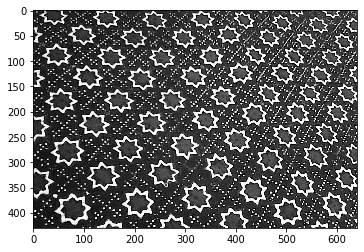

In [13]:
#### Main

#Calculate time elapsed for a model
time_modelling_start = timeit.default_timer()

# Defining paths
root_path = './'
training_folder_path = root_path + 'training/'
validation_folder_path = root_path + 'validation/'
test_folder_path = root_path + 'test/'

# Defining model specifications
img_type = '*.jpg'
sampling_count = 128
k_neighbors = 1
glcm_angle = 0
glcm_distance = 1
glcm_filter = (-0.19403910584244866, -0.5500753452783025, 4.132468367500618, 0.6403881637541744)
glcm_formula = '0, 1, 2, 3'

# Initializing
initialize_model()
class_names = get_class_names(training_folder_path)
add_classes_to_model(class_names)

# Training
train(training_folder_path, img_type, sampling_count, glcm_angle, glcm_distance)

# Validating
model_accuracy = validate(validation_folder_path, img_type, sampling_count, k_neighbors, glcm_angle, glcm_distance, glcm_filter, glcm_formula)

#Calculate time elapsed for a model
time_modelling_stop = timeit.default_timer()

# Testing
test_img_path = test_folder_path + 'cap2.jpg'
test_img = load_img(test_img_path)
test_img_class = get_img_class(test_img, sampling_count, k_neighbors, glcm_angle, glcm_distance, glcm_filter, glcm_formula)
print('This image is categorized as batik ' + test_img_class + '.')
print_img(test_img)

#Calculate time elapsed for a classification
time_classification_end = timeit.default_timer()


#Print total time elapsed for a model
print('\n\n')
print('Model specifications')
print('====================')
print('Image type         : ' + img_type)
print('Sampling count     : ' + str(sampling_count))
print('K-neighbors        : ' + str(k_neighbors))
print('GLCM Angle (deg)   : ' + str(glcm_angle))
print('GLCM distance      : ' + str(glcm_distance))
print('GLCM filter        : ' + str(glcm_filter))
print('GLCM formula       : ' + str(glcm_formula))
print()
print('Model\'s accuracy is around ' + str(model_accuracy) + '%')
print('Time elapsed to make this model is ' + str(time_stop - time_start) + ' seconds.')
print()
print('Time elapsed to classify one image is ' + str(time_classification_end - time_modelling_stop) + ' seconds.')

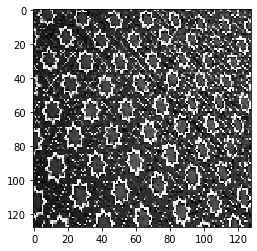

In [11]:
img = load_img('./test/cap2.jpg')
img_colors = get_img_colors(img, 128)
down_img = construct_img(img_colors, (128, 128), 128)
print_img(down_img)

In [57]:
#### Global variable for Formula research

formulas = {}
global_maximum_accuracy = 0
global_maximum_accuracy_formula = ''
global_maximum_accuracy_filter = (1, 1, 1, 1)


In [58]:
#### Functions for Formula research

def get_random_formula():
    index_list = [0, 1, 2, 3]
    
    is_complete = False
    is_first_time = True
    previous_char = ''
    comma_count = 0
    formula = ''
    temp_formula = []
    while(not is_complete):
        dice = random.randint(0, 1)
        if(dice == 0 and not is_first_time and comma_count < 3 and not previous_char == ','):
            if(len(temp_formula) > 0):
                temp_formula = sorted(temp_formula)
                temp_formula_str = ''
                temp_formula_str = temp_formula_str.join(temp_formula)
                formula += temp_formula_str
                temp_formula = []
            formula += ','
            previous_char = ','
            comma_count += 1
        else:
            current_index = index_list[0]
            if(not previous_char == ',' and not previous_char == ''):
                random_index = random.randint(0, len(index_list) - 1)
                current_index = index_list[random_index]
                temp_formula += str(current_index)
                del index_list[random_index]
            else:
                formula += str(current_index)
                del index_list[0]
            previous_char = str(current_index)
            
        is_first_time = False
        
        if(len(index_list) == 0):
            if(len(temp_formula) > 0):
                temp_formula = sorted(temp_formula)
                temp_formula_str = ''
                temp_formula_str = temp_formula_str.join(temp_formula)
                formula += temp_formula_str
            is_complete = True             
                
    
    return formula


In [81]:
#### Main for Formula research

# Calculate research time
research_time_start = timeit.default_timer()

n_epochs = 125
maximum_accuracy = 0
maximum_accuracy_formula = ''
maximum_accuracy_filter = (1, 1, 1, 1)

for epoch in range(n_epochs):
    random_start = -2
    random_stop  = 5
    
    glcm_formula = get_random_formula()
    glcm_filter = (random.uniform(random_start, random_stop), random.uniform(random_start, random_stop), random.uniform(random_start, random_stop), random.uniform(random_start, random_stop))
    
    print(glcm_formula)
    print(glcm_filter)
    
    current_accuracy = validate(validation_folder_path, img_type, sampling_count, k_neighbors, glcm_angle, glcm_distance, glcm_filter, glcm_formula)
    print()
    
    # add the formula to dictionary
    if(not glcm_formula in formulas):
        formulas[glcm_formula] = []
    formulas[glcm_formula].append((glcm_filter, current_accuracy))
    
    if(current_accuracy > maximum_accuracy):
        maximum_accuracy = current_accuracy
        maximum_accuracy_formula = glcm_formula
        maximum_accuracy_filter = glcm_filter
    
if(global_maximum_accuracy < maximum_accuracy):
    global_maximum_accuracy = maximum_accuracy
    global_maximum_accuracy_formula = maximum_accuracy_formula
    global_maximum_accuracy_filter = maximum_accuracy_filter
    
# Calculate research time
research_time_stop = timeit.default_timer()
research_time = (research_time_stop - research_time_start) / 60
    
print('Completed in ' + str(research_time) + ' minutes.')
print()
print('Maximum accuracy = ' + str(maximum_accuracy) + '%')
print('GLCM Formula     = ' + maximum_accuracy_formula)
print('GLCM Filter      = ' + str(maximum_accuracy_filter))
print()
print('TOP GLOBAL FORMULA')
print('Maximum accuracy = ' + str(global_maximum_accuracy) + '%')
print('GLCM Formula     = ' + global_maximum_accuracy_formula)
print('GLCM Filter      = ' + str(global_maximum_accuracy_filter))

0,1,2,3
(-1.8272101736702933, 2.5296573436722705, 4.806789122356884, 4.88983017285898)
Accuracy = 67.1875%

0,12,3
(0.8130144680693152, 1.3485094320131203, 2.1459796316516577, 4.285303804188183)
Accuracy = 66.015625%

0,1,23
(4.8009879454994255, 4.853037083892987, 0.4566782488238421, -1.1315450367453643)
Accuracy = 66.40625%

03,12
(-1.6915616464031817, 4.103297634439528, -0.8983382670927196, 0.768383053771351)
Accuracy = 65.234375%

0,1,2,3
(3.31933584779138, -1.7342697469040358, -0.9951562238281018, 2.48759574657175)
Accuracy = 65.234375%

0,1,23
(4.421706405614576, 1.7780385119814905, -1.5209542938223808, 2.746363029851058)
Accuracy = 67.1875%

0,1,2,3
(0.6114406262959315, 3.4493282463171466, -0.7132419519163737, 0.5238828492182717)
Accuracy = 67.1875%

01,23
(-1.4234281601929906, 2.5792797004200834, -0.8473052980075195, 1.2920007412489043)
Accuracy = 64.84375%

0,123
(0.8782894862236432, -0.037739832951821484, 0.4953394194905414, 1.2871114675827457)
Accuracy = 64.0625%

0,1,2,3
(3.

Accuracy = 62.109375%

0,1,23
(0.41281199950452674, -0.7851479268262609, 3.3986423994436894, 3.7487241528348108)
Accuracy = 68.75%

01,2,3
(0.3166277178923158, -0.9057986439107581, -0.9538157798998061, -0.9770705718449468)
Accuracy = 64.0625%

0,13,2
(1.0812360542150685, 2.541041802124073, 2.841866851146051, -0.7126827223959507)
Accuracy = 67.96875%

0,123
(-1.9097034990780546, -0.9259868117247083, 2.1115837154294708, 2.205413602828119)
Accuracy = 68.75%

03,1,2
(0.02848931376581465, -0.5745565122618588, 1.9357251351258364, 3.144630103706625)
Accuracy = 63.671875%

03,12
(0.26712834881074166, -1.7796647205221094, -0.04765860390140042, 0.04214307350255586)
Accuracy = 66.796875%

0,1,2,3
(-1.585655701606545, 2.308058103145024, 0.988531414970184, 0.7657433894975276)
Accuracy = 65.625%

0,1,2,3
(2.620428900010662, -0.6360234640471121, 4.5686794149522925, 1.4715546016919197)
Accuracy = 69.140625%

0,13,2
(2.1835183283705684, 3.076497921168176, -0.40558067662515884, -0.41887616640009573)
Acc

In [75]:
sorted_formulas_key = sorted(formulas)
sorted_formulas = {}

for key in sorted_formulas_key:
    sorted_formulas[key] = sorted(formulas[key], key=lambda x: -1 * x[1])
    

    
for formula in sorted_formulas:
    print('Formula: ' + formula)
    print('====================')
    
    for filter_accuracy in sorted_formulas[formula]:
        print(filter_accuracy)
    
    print('\n\n')

Formula: 0,1,2,3
((-0.19403910584244866, -0.5500753452783025, 4.132468367500618, 0.6403881637541744), 74.21875)
((-0.20292312035683366, -0.5491982945325539, 4.134577668188368, 0.6443190078394445), 74.21875)
((-0.1865775658138007, -0.5319883934584009, 4.110468765196114, 0.6643010020040357), 74.21875)
((-0.18141170283404645, -0.5524086640112799, 4.125473582170488, 0.6663413580555969), 74.21875)
((-0.17464996580359002, -0.5578275097296471, 4.136477727039946, 0.6297653276341403), 73.828125)
((-0.2075616153849204, -0.5191315155728022, 4.104548692611998, 0.729095863804375), 73.828125)
((-0.198362977467986, -0.5561080126104279, 4.124026665167636, 0.6626822169472594), 73.828125)
((-0.19768931393479713, -0.5267618896922927, 4.105169302150438, 0.6465171659207758), 73.828125)
((-0.19846334190253762, -0.5436233797081834, 4.108081680998899, 0.691325434109946), 73.828125)
((-0.21002521474493183, -0.6019196034760796, 4.145650067269538, 0.7328585834036626), 73.4375)
((-0.13366114399715184, -0.46445479

In [147]:
19.671846698333336 minutes.
8.430353055000001 

#Pooling 4 -> 2 (concor, enehom)
    #(1, 1, 1, 1)     = 62%
    #(1, 1, 1, -1)    = 62%
    #(1, 1, -1, 1)    = 62%
    #(1, 1, -1, -1)   = 62%
    #(1, -1, 1, 1)    = 70%
    #(1, -1, 1, -1)   = 67%
    #(1, -1, -1, 1)   = 67%
    #(1, -1, -1, -1)  = 70%
    #(-1, 1, 1, 1)    = 70%
    #(-1, 1, 1, -1)   = 67%
    #(-1, 1, -1, 1)   = 67%
    #(-1, 1, -1, -1)  = 70%
    #(-1, -1, 1, 1)   = 62%
    #(-1, -1, 1, -1)  = 62%
    #(-1, -1, -1, 1)  = 62%
    #(-1, -1, -1, -1) = 62%
    
    #Pooling 4 -> 1
    #(1, 1, 1, 1)     = 62%
    #(1, 1, 1, -1)    = 65%
    #(1, 1, -1, 1)    = 58%
    #(1, 1, -1, -1)   = 62%
    #(1, -1, 1, 1)    = 61%
    #(1, -1, 1, -1)   = 61%
    #(1, -1, -1, 1)   = 62%
    #(1, -1, -1, -1)  = 64%
    #(-1, 1, 1, 1)    = 65%
    #(-1, 1, 1, -1)   = 62%
    #(-1, 1, -1, 1)   = 61%
    #(-1, 1, -1, -1)  = 61%
    #(-1, -1, 1, 1)   = 62%
    #(-1, -1, 1, -1)  = 58%
    #(-1, -1, -1, 1)  = 65%
    #(-1, -1, -1, -1) = 62%

In [ ]:
"""

Maximum accuracy = 70.3125%
GLCM Formula     = 01,2,3
GLCM Filter      = (-0.739719747924053, -0.1334701800968987, 1.2037508410731208, 1.5543226205846352)

Maximum accuracy = 70.3125%
GLCM Formula     = 20,31
GLCM Filter      = (1.4001996095237867, -0.5328392029226576, 0.5963419333522879, 1.2703218205046967)

Maximum accuracy = 70.703125%
GLCM Formula     = 21,30
GLCM Filter      = (-0.44882604130389636, 0.5529680381937516, 1.9124275421371872, -0.7013035337080564)

Maximum accuracy = 71.09375%
GLCM Formula     = 2,3,10
GLCM Filter      = (0.4499061937644382, -0.02514871184338041, -0.7910805702784743, 1.507831947960577)

Maximum accuracy = 71.09375%
GLCM Formula     = 1, 0, 3, 2
GLCM Filter      = (0.37987534187980687, -0.8730379522769771, 1.9149935462464271, -0.8340724507504323)

Maximum accuracy = 72.65625%
GLCM Formula     = 1, 0, 3, 2
GLCM Filter      = (0.37987534187980687, -0.8730379522769771, 1.9149935462464271, -0.9887629454412322)

Maximum accuracy = 73.046875%
GLCM Formula     = 0,1,23
GLCM Filter      = (0.3904096306540641, -3.988121527555746, -4.437901343398643, 2.692473856606944)

Maximum accuracy = 74.21875%
GLCM Formula     = 0,1,2,3
GLCM Filter      = (-0.19403910584244866, -0.5500753452783025, 4.132468367500618, 0.6403881637541744)


"""